In [1]:
import unicodedata
import re
import json
import os
from requests import get
from bs4 import BeautifulSoup
import acquire
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

import pandas as pd
from acquire import parse_blog
from acquire import get_article_text
from acquire import get_codeup_blogs
from acquire import get_inshorts_articles
from acquire import prep_text

In [2]:
# Store contents of 'spam.csv' into a variable
spam = pd.read_csv('spam.csv')

In [3]:
# Check column names.
spam.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [4]:
# Drop unwanted columns.
spam.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'], inplace=True)

In [5]:
# Rename columns.
spam.rename(columns={'v1':'label','v2':'text'}, inplace=True)

In [6]:
spam

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will �_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [7]:
# Add words to append to list of stopwords.
ADDITIONAL_STOPWORDS = ['r','u','2','ltgt']

# This function will append list of words to stopwords
def clean(text):
    # Create lemmatizer object
    wnl = nltk.stem.WordNetLemmatizer()
    # Create list of stopwords
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    # Convert string to ASCII character set.
    text = (unicodedata.normalize('NFKD', text)
           .encode('ascii','ignore')
           .decode('utf-8','ignore')
           .lower())
    # Remove special characters.
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [8]:
# This function shows number of words and their ratio of occurence.
def show_counts_and_ratios(df, column):
    labels = pd.concat([spam.label.value_counts(),
                       spam.label.value_counts(normalize=True)], axis =1)
    labels.columns = ['n', 'percent']
    return labels

In [9]:
show_counts_and_ratios(spam, 'label')

,n,percent
ham,4825,0.865937
spam,747,0.134063


In [10]:
# Convert dataframe into text.
ham_words = clean(' '.join(spam[spam.label == 'ham'].text))
spam_words = clean(' '.join(spam[spam.label == 'spam'].text))
all_words = clean(' '.join(spam.text))

In [11]:
# Check top 5 words in each list.
ham_words[:5], spam_words[:5], all_words[:5]

(['go', 'jurong', 'point', 'crazy', 'available'],
 ['free', 'entry', 'wkly', 'comp', 'win'],
 ['go', 'jurong', 'point', 'crazy', 'available'])

In [12]:
# Get value counts of each word in each list.
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

spam_freq.head()

call    359
free    216
txt     150
ur      144
text    137
dtype: int64

In [13]:
pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)

,0,1,2
0,3,NaN,3.0
008704050406,2,NaN,2.0
0089my,1,NaN,1.0
0121,1,NaN,1.0
01223585236,1,NaN,1.0
...,...,...,...
zoe,2,1.0,1.0
zogtorius,1,1.0,NaN
zoom,1,1.0,NaN
zouk,1,NaN,1.0


In [14]:
# Combine value counts of words into one dataframe to work on

word_counts = (pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)
              .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
              .fillna(0) 
              .apply(lambda s: s.astype(int)))

word_counts

,all,ham,spam
0,3,0,3
008704050406,2,0,2
0089my,1,0,1
0121,1,0,1
01223585236,1,0,1
...,...,...,...
zoe,2,1,1
zogtorius,1,1,0
zoom,1,1,0
zouk,1,0,1


### Are there any words that uniquely identify a spam or ham message?

In [15]:
pd.concat([word_counts[word_counts.ham == 0].sort_values(by='spam', ascending=False).head(10),
          word_counts[word_counts.spam == 0].sort_values(by='ham', ascending=False).head(10)])

,all,ham,spam
claim,115,0,115
prize,94,0,94
tone,73,0,73
guaranteed,50,0,50
500,44,0,44
18,43,0,43
150,39,0,39
awarded,38,0,38
150ppm,34,0,34
ringtone,27,0,27


### What are the most frequently occuring words?

In [16]:
word_counts.sort_values(by='all', ascending=False)

,all,ham,spam
call,600,241,359
im,471,458,13
get,397,314,83
ur,384,240,144
go,304,273,31
...,...,...,...
lyricalladie21f,1,0,1
lyric,1,1,0
lyk,1,1,0
lying,1,1,0


## Visualization

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Proportion of Spam vs Ham for the 20most common words')

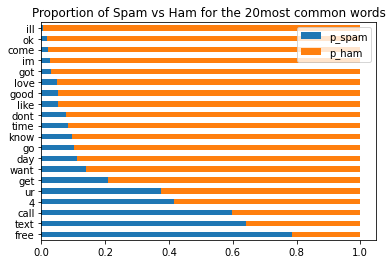

In [18]:
# Plot the ratios of spam and ham words.
(word_counts
.assign(p_spam=word_counts.spam / word_counts['all'],
        p_ham=word_counts.ham / word_counts['all'])
.sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(20)
 .sort_values('p_ham')
 .plot.barh(stacked=True))

plt.title('Proportion of Spam vs Ham for the 20most common words')

In [19]:
# Get values and ratios of all words that have a value count greater than 10.
(word_counts
[(word_counts.spam > 10) & (word_counts.ham > 10)]
.assign(ratio=lambda df: df.spam / (df.ham + .01))
.sort_values(by='ratio')
.pipe(lambda df: pd.concat([df.head(), df.tail()])))

,all,ham,spam,ratio
im,471,458,13,0.028384
good,235,223,12,0.053809
like,245,232,13,0.056032
need,182,171,11,0.064324
dont,290,268,22,0.082086
contact,70,14,56,3.997145
win,76,15,61,4.063957
cash,74,12,62,5.162365
mobile,150,15,135,8.994004
txt,163,13,150,11.529593


(-0.5, 399.5, 199.5, -0.5)

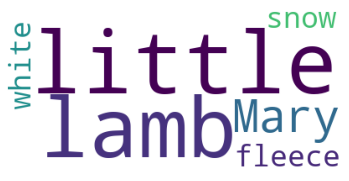

In [20]:
from wordcloud import WordCloud

# Create sentence for wordcloud
sentence = "Mary had a little lamb, little lamb, little lamb. Its fleece was white as snow."

# Generate the image using previously stored sentence.
img = WordCloud(background_color='white').generate(sentence)

# Display image.
plt.imshow(img)
plt.axis('off')

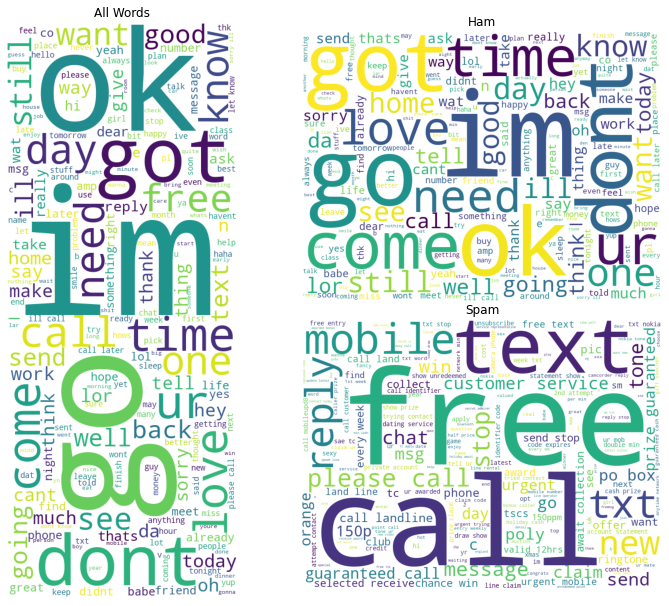

In [21]:
# Generate images from joining all words in the list into one 'sentence' using '.join'
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
ham_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ham_words))
spam_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(spam_words))

plt.figure(figsize=(10,8))
axs = [plt.axes([0,0,.5,1]), plt.axes([.5,.5,.5,.5]), plt.axes([.5,0,.5,.5])]

axs[0].imshow(all_cloud)
axs[1].imshow(ham_cloud)
axs[2].imshow(spam_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Ham')
axs[2].set_title('Spam')

for ax in axs: ax.axis('off')

## Bigrams

In [22]:
sentence = "Mary had a little lamb"

bigrams = nltk.ngrams(sentence.split(), 2)
list(bigrams)

[('Mary', 'had'), ('had', 'a'), ('a', 'little'), ('little', 'lamb')]

In [23]:
top_20_ham_bigrams = (pd.Series(nltk.ngrams(ham_words, 2))
                     .value_counts()
                     .head(20))

top_20_ham_bigrams

(call, later)      52
(ill, call)        48
(let, know)        42
(sorry, ill)       39
(dont, know)       33
(good, morning)    31
(new, year)        30
(im, going)        26
(take, care)       26
(ok, lor)          22
(pls, send)        22
(im, gonna)        20
(good, night)      19
(happy, new)       19
(wat, time)        18
(last, night)      18
(hi, hi)           18
(great, day)       17
(dont, want)       15
(want, go)         15
dtype: int64

In [24]:
top_20_ham_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])

0       call later
1         ill call
2         let know
3        sorry ill
4        dont know
5     good morning
6         new year
7         im going
8        take care
9           ok lor
10        pls send
11        im gonna
12      good night
13       happy new
14        wat time
15      last night
16           hi hi
17       great day
18       dont want
19         want go
Name: index, dtype: object

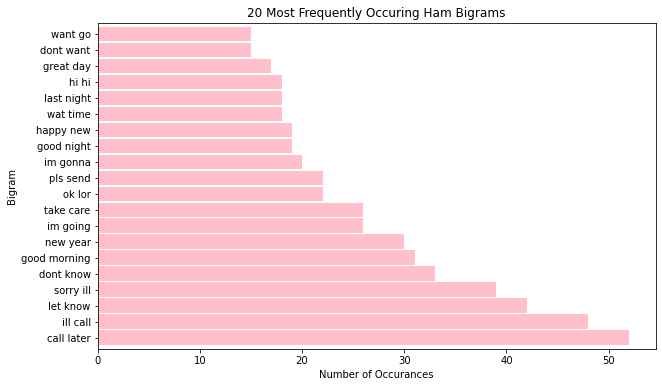

In [25]:
top_20_ham_bigrams.plot.barh(color='pink', width=.9, figsize=(10,6))

plt.title('20 Most Frequently Occuring Ham Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Number of Occurances')

ticks , _ = plt.yticks()
labels = top_20_ham_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

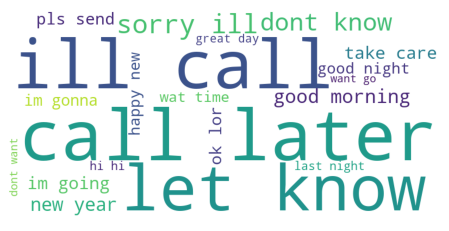

In [26]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_ham_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8,4))
plt.imshow(img)
plt.axis('off')
plt.show()

## Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?

In [27]:
top_20_spam_bigrams = (pd.Series(nltk.ngrams(spam_words, 2))
                      .value_counts()
                      .head(20))

top_20_spam_bigrams

(please, call)          44
(customer, service)     27
(1000, cash)            25
(po, box)               24
(guaranteed, call)      23
(prize, guaranteed)     22
(chance, win)           19
(selected, receive)     19
(send, stop)            19
(every, week)           19
(await, collection)     19
(show, 800)             18
(land, line)            18
(urgent, mobile)        18
(valid, 12hrs)          17
(claim, call)           17
(call, 08000930705)     16
(account, statement)    16
(sae, tc)               16
(prize, claim)          16
dtype: int64

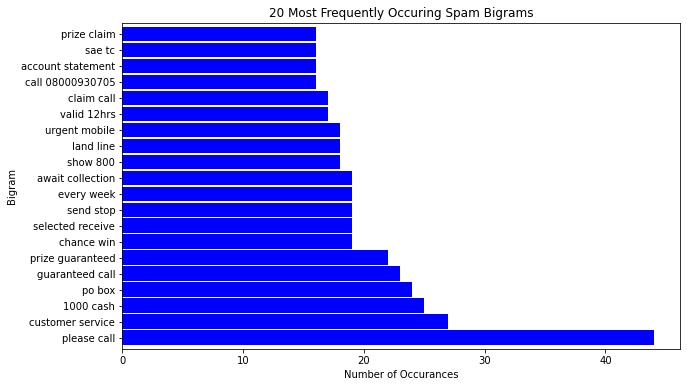

In [28]:
top_20_spam_bigrams.plot.barh(color='blue', width=.9, figsize=(10,6))

plt.title('20 Most Frequently Occuring Spam Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Number of Occurances')

# Make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_spam_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

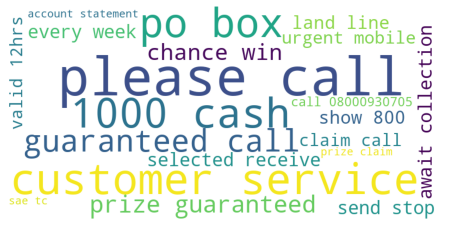

In [29]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_spam_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8,4))
plt.imshow(img)
plt.axis('off')
plt.show()

## Create and explore with trigrams(i.e. an n-gram with an n of 3) for both the spam and ham data.

In [30]:
top_20_ham_trigrams = (pd.Series(nltk.ngrams(ham_words, 3))
                     .value_counts()
                     .head(20))

top_20_ham_trigrams

(ill, call, later)          42
(sorry, ill, call)          38
(happy, new, year)          19
(pls, send, message)        13
(phone, right, pls)         12
(cant, pick, phone)         12
(right, pls, send)          12
(pick, phone, right)        12
(hi, hi, hi)                11
(x, x, x)                    8
(good, morning, dear)        7
(call, later, meeting)       6
(convey, birthday, wish)     6
(pls, convey, birthday)      6
(kiss, across, sea)          6
(even, colleague, wish)      5
(sad, story, man)            5
(9, copy, friend)            5
(press, 9, copy)             5
(askd, 4, lunch)             5
dtype: int64

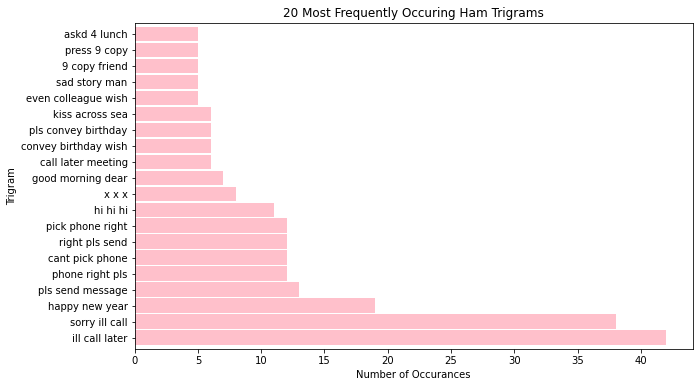

In [31]:
top_20_ham_trigrams.plot.barh(color='pink', width=.9, figsize=(10,6))

plt.title('20 Most Frequently Occuring Ham Trigrams')
plt.ylabel('Trigram')
plt.xlabel('Number of Occurances')

ticks, _ = plt.yticks()
labels = top_20_ham_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

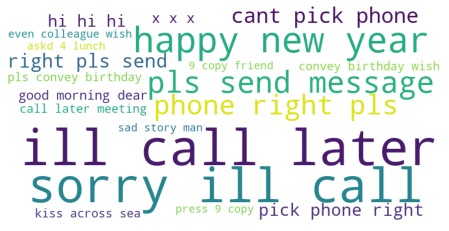

In [32]:
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_20_ham_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8,4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [33]:
top_20_spam_trigrams = (pd.Series(nltk.ngrams(spam_words, 3))
                      .value_counts()
                      .head(20))

top_20_spam_trigrams

(prize, guaranteed, call)              21
(call, customer, service)              15
(land, line, claim)                    14
(reply, call, 08000930705)             14
(2003, account, statement)             13
(private, 2003, account)               13
(show, 800, unredeemed)                12
(guaranteed, 1000, cash)               12
(camcorder, reply, call)               12
(anytime, network, min)                11
(tone, 4, ur)                          11
(urgent, trying, contact)              11
(every, week, txt)                     11
(please, call, customer)               11
(bonus, caller, prize)                 11
(customer, service, representative)    10
(speak, live, operator)                10
(1000, cash, 2000)                     10
(cash, await, collection)              10
(2000, bonus, caller)                  10
dtype: int64

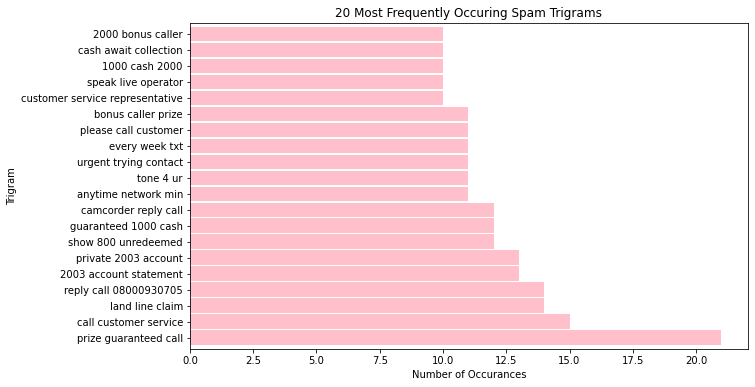

In [34]:
top_20_spam_trigrams.plot.barh(color='pink', width=.9, figsize=(10,6))

plt.title('20 Most Frequently Occuring Spam Trigrams')
plt.ylabel('Trigram')
plt.xlabel('Number of Occurances')

ticks, _ = plt.yticks()
labels = top_20_spam_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

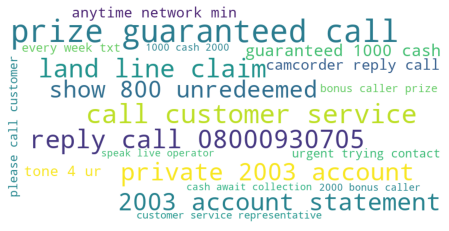

In [35]:
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_20_spam_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8,4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [36]:
codeup_df = acquire.get_codeup_blogs(cached=True)

In [37]:
codeup_df

,title,date & source,original
0,Codeup Dallas Open House,"Nov 30, 2021 | Dallas Newsletter, Events",\nCome join us for the re-opening of our Dalla...
1,Codeup’s Placement Team Continues Setting Records,"Nov 19, 2021 | Codeup News, Employers",\n\n\n\n\n\nOur Placement Team is simply defin...
2,"IT Certifications 101: Why They Matter, and Wh...","Nov 18, 2021 | IT Training, Tips for Prospecti...","\n\n\n\n\n\nAWS, Google, Azure, Red Hat, CompT..."
3,A rise in cyber attacks means opportunities fo...,"Nov 17, 2021 | Cybersecurity","\nIn the last few months, the US has experienc..."
4,Use your GI Bill® benefits to Land a Job in Tech,"Nov 4, 2021 | Codeup News, Tips for Prospectiv...",\n\n\n\n\n\nAs the end of military service get...
5,Which program is right for me: Cyber Security ...,"Oct 28, 2021 | IT Training, Tips for Prospecti...",\n\n\n\n\n\nWhat IT Career should I choose?\nI...
6,What the Heck is System Engineering?,"Oct 21, 2021 | IT Training, Tips for Prospecti...",\n\n\n\n\n\nCodeup offers a 13-week training p...
7,From Speech Pathology to Business Intelligence,"Oct 18, 2021 | Alumni Stories",\n\n\n\n\n\nBy: Alicia Gonzalez\nBefore Codeup...
8,Boris – Behind the Billboards,"Oct 3, 2021 | Behind the Billboards",\n\n\n
9,Is Codeup the Best Bootcamp in San Antonio…or ...,"Sep 16, 2021 | Codeup News, Featured",\n\n\n\n\n\nLooking for the best data science ...


In [38]:
acquire.prep_text(codeup_df, 'original')

,title,original,clean,stemmed,lemmatized
0,Codeup Dallas Open House,\nCome join us for the re-opening of our Dalla...,come join us reopening dallas campus drinks sn...,come join us reopen dalla campu drink snack co...,come join u reopening dallas campus drink snac...
1,Codeup’s Placement Team Continues Setting Records,\n\n\n\n\n\nOur Placement Team is simply defin...,placement team simply defined group manages re...,placement team simpli defin group manag relati...,placement team simply defined group manages re...
2,"IT Certifications 101: Why They Matter, and Wh...","\n\n\n\n\n\nAWS, Google, Azure, Red Hat, CompT...",aws google azure red hat comptiathese big name...,aw googl azur red hat comptiathes big name onl...,aws google azure red hat comptiathese big name...
3,A rise in cyber attacks means opportunities fo...,"\nIn the last few months, the US has experienc...",last months us experienced dozens major cybera...,last month us ha experienc dozen major cyberat...,last month u ha experienced dozen major cybera...
4,Use your GI Bill® benefits to Land a Job in Tech,\n\n\n\n\n\nAs the end of military service get...,end military service gets closer many transiti...,end militari servic get closer mani transit se...,end military service get closer many transitio...
5,Which program is right for me: Cyber Security ...,\n\n\n\n\n\nWhat IT Career should I choose?\nI...,career choose youre thinking career lot direct...,career choos think career lot direct could go ...,career choose youre thinking career lot direct...
6,What the Heck is System Engineering?,\n\n\n\n\n\nCodeup offers a 13-week training p...,codeup offers 13week training program systems ...,codeup offer 13week train program system engin...,codeup offer 13week training program system en...
7,From Speech Pathology to Business Intelligence,\n\n\n\n\n\nBy: Alicia Gonzalez\nBefore Codeup...,alicia gonzalez codeup home health speechlangu...,alicia gonzalez befor codeup wa home health sp...,alicia gonzalez codeup wa home health speechla...
8,Boris – Behind the Billboards,\n\n\n,,,
9,Is Codeup the Best Bootcamp in San Antonio…or ...,\n\n\n\n\n\nLooking for the best data science ...,looking best data science bootcamp world best ...,look best data scienc bootcamp world best code...,looking best data science bootcamp world best ...


In [39]:
news_df = get_inshorts_articles()

In [40]:
news_df

,title,author,original,date,category
0,"Indian scientists develop self-disinfecting, w...",Ridham Gambhir,The Ministry of Science and Technology on Frid...,2022-02-04,science
1,New 'highly virulent' variant of HIV discovere...,Ankush Verma,"Scientists have discovered a new ""highly virul...",2022-02-04,science
2,NASA to retire International Space Station by ...,Ridham Gambhir,NASA has announced that the International Spac...,2022-02-04,science
3,Construction machinery destroys several fossil...,Ridham Gambhir,Several scientists and palaeontologists have u...,2022-02-06,science
4,9.9 crore-year-old flowers found perfectly pre...,Ankush Verma,Two 9.9 crore-year-old flowers have been found...,2022-02-02,science
...,...,...,...,...,...
120,Lata ji's 'Ae mere watan ke logo' song leaves ...,Disha Jana,Defence Minister Rajnath Singh paid tribute to...,2022-02-06,entertainment
121,"She sounded like an angel, now she becomes one...",Ria Kapoor,Actor Boman Irani expressed his condolences af...,2022-02-06,entertainment
122,"Spent her last 10 days with her, left nothing ...",Ria Kapoor,Actor Andrew Garfield said he got to spend tim...,2022-02-06,entertainment
123,Rahul pays tribute to Lata Mangeshkar at virtu...,Disha Jana,Former Congress chief Rahul Gandhi paid tribut...,2022-02-06,entertainment


In [41]:
prep_text(news_df, 'original', extra_words=["'", ','])

,title,original,clean,stemmed,lemmatized
0,"Indian scientists develop self-disinfecting, w...",The Ministry of Science and Technology on Frid...,ministry science technology friday announced t...,ministri scienc technolog friday announc team ...,ministry science technology friday announced t...
1,New 'highly virulent' variant of HIV discovere...,"Scientists have discovered a new ""highly virul...",scientists discovered new highly virulent vari...,scientist discov new highli virul variant hiv ...,scientist discovered new highly virulent varia...
2,NASA to retire International Space Station by ...,NASA has announced that the International Spac...,nasa announced international space station con...,nasa ha announc intern space station continu w...,nasa ha announced international space station ...
3,Construction machinery destroys several fossil...,Several scientists and palaeontologists have u...,several scientists palaeontologists urged us b...,sever scientist palaeontologist urg us bureau ...,several scientist palaeontologist urged u bure...
4,9.9 crore-year-old flowers found perfectly pre...,Two 9.9 crore-year-old flowers have been found...,two 99 croreyearold flowers found perfectly pr...,two 99 croreyearold flower found perfectli pre...,two 99 croreyearold flower found perfectly pre...
...,...,...,...,...,...
120,Lata ji's 'Ae mere watan ke logo' song leaves ...,Defence Minister Rajnath Singh paid tribute to...,defence minister rajnath singh paid tribute la...,defenc minist rajnath singh paid tribut late s...,defence minister rajnath singh paid tribute la...
121,"She sounded like an angel, now she becomes one...",Actor Boman Irani expressed his condolences af...,actor boman irani expressed condolences vetera...,actor boman irani express hi condol veteran si...,actor boman irani expressed condolence veteran...
122,"Spent her last 10 days with her, left nothing ...",Actor Andrew Garfield said he got to spend tim...,actor andrew garfield said got spend time moth...,actor andrew garfield said got spend time hi m...,actor andrew garfield said got spend time moth...
123,Rahul pays tribute to Lata Mangeshkar at virtu...,Former Congress chief Rahul Gandhi paid tribut...,former congress chief rahul gandhi paid tribut...,former congress chief rahul gandhi paid tribut...,former congress chief rahul gandhi paid tribut...


In [42]:
news_df.original[3]

'Several scientists and palaeontologists have urged the US Bureau of Land Management to stop construction on a walkway at the Mill Canyon Dinosaur Tracksite in Utah, stating that some fossilised dinosaur footprints have been damaged by construction machinery. The Mill Canyon tracksite contains tracks from at least 10 dinosaur species, thought to have lived around 112 million years ago.'

## Create a separate dataframe for each category.

In [43]:
pd.set_option('display.max_colwidth', None)

In [44]:
list_of_dfs = []
for cat in news_df.category.unique():
    list_of_dfs.append(news_df[news_df.category == cat])

In [45]:
news_df.clean[0:21]

0                                                                   ministry science technology friday announced team indian scientists developed selfdisinfecting antiviral mask fight covid19 mask biodegradable highly breathable washable nature per ministry coated copperbased nanoparticles efficient coronavirus well viral bacterial infections
1                                                                           scientists discovered new highly virulent variant hiv netherlands individuals infected vb variant viral load 35 55 times higher infected variants researchers including university oxford said variant likely arose late 1980s early 1990s netherlands according researchers
2                                                                                                   nasa announced international space station continue working till 2030 crash uninhabited stretch pacific ocean early 2031 20 years 1998 launch iss would crash part called point nemo also known spacecraft cemeter

In [46]:
news_df.lemmatized[0:4]

0                             ministry science technology friday announced team indian scientist developed selfdisinfecting antiviral mask fight covid19 mask biodegradable highly breathable washable nature per ministry coated copperbased nanoparticles efficient coronavirus well viral bacterial infection
1                                         scientist discovered new highly virulent variant hiv netherlands individual infected vb variant viral load 35 55 time higher infected variant researcher including university oxford said variant likely arose late 1980s early 1990s netherlands according researcher
2                                                             nasa ha announced international space station continue working till 2030 crash uninhabited stretch pacific ocean early 2031 20 year 1998 launch would crash part called point nemo also known spacecraft cemetery region known lack human activity
3    several scientist palaeontologist urged u bureau land management stop constructi

In [47]:
news_df.stemmed[0:4]

0                                     ministri scienc technolog friday announc team indian scientist develop selfdisinfect antivir mask fight covid19 mask biodegrad highli breathabl washabl natur per ministri coat copperbas nanoparticl effici coronaviru well viral bacteri infect
1                                                 scientist discov new highli virul variant hiv netherland individu infect vb variant viral load 35 55 time higher infect variant research includ univers oxford said variant like aros late 1980 earli 1990 netherland accord research
2                                                      nasa ha announc intern space station continu work till 2030 crash uninhabit stretch pacif ocean earli 2031 20 year 1998 launch iss would crash part call point nemo also known spacecraft cemeteri region known lack human activ
3    sever scientist palaeontologist urg us bureau land manag stop construct walkway mill canyon dinosaur tracksit utah state fossilis dinosaur footprint damag 

# Takeaways
* There is not much difference between the lemmatized and clean versions. The stemmed version is difficult for me to understand. 
* I will work on the clean version of text for exploration.

In [48]:
news_df.category.unique()

array(['science', 'business', 'sports', 'technology', 'entertainment'],
      dtype=object)

In [49]:
# Create a corpus of words for each category.
science_words = ' '.join(news_df[news_df.category == 'science'].clean)
business_words = ' '.join(news_df[news_df.category == 'business'].clean)
sports_words = ' '.join(news_df[news_df.category == 'sports'].clean)
technology_words = ' '.join(news_df[news_df.category == 'technology'].clean)
entertainment_words = ' '.join(news_df[news_df.category == 'entertainment'].clean)
all_words = ' '.join(news_df.clean)

In [50]:
len(science_words), len(business_words), len(sports_words), len(technology_words), len(entertainment_words), len(all_words)

(7033, 6693, 6709, 6534, 6226, 33199)

In [51]:
science_words

'ministry science technology friday announced team indian scientists developed selfdisinfecting antiviral mask fight covid19 mask biodegradable highly breathable washable nature per ministry coated copperbased nanoparticles efficient coronavirus well viral bacterial infections scientists discovered new highly virulent variant hiv netherlands individuals infected vb variant viral load 35 55 times higher infected variants researchers including university oxford said variant likely arose late 1980s early 1990s netherlands according researchers nasa announced international space station continue working till 2030 crash uninhabited stretch pacific ocean early 2031 20 years 1998 launch iss would crash part called point nemo also known spacecraft cemetery region known lack human activity several scientists palaeontologists urged us bureau land management stop construction walkway mill canyon dinosaur tracksite utah stating fossilised dinosaur footprints damaged construction machinery mill can

### Represent text as word frequencies

In [52]:
science_freq = pd.Series(science_words.split()).value_counts()
business_freq = pd.Series(business_words.split()).value_counts()
sports_freq = pd.Series(sports_words.split()).value_counts()
technology_freq = pd.Series(technology_words.split()).value_counts()
entertainment_freq = pd.Series(entertainment_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()

In [53]:
word_counts = pd.concat([science_freq, business_freq, sports_freq, technology_freq, entertainment_freq, all_freq], axis=1).fillna(0).astype(int)
word_counts.columns = ['science','business','sports','technology','entertainment','all']

In [54]:
word_counts

,science,business,sports,technology,entertainment,all
said,17,15,8,13,14,67
nasa,11,0,0,0,0,11
space,9,0,0,0,0,9
researchers,9,0,0,0,0,9
scientists,8,0,0,1,0,9
...,...,...,...,...,...,...
mangeshkarshe,0,0,0,0,1,1
waiting,0,0,0,0,1,1
jaya,0,0,0,0,1,1
faye,0,0,0,0,1,1


In [55]:
word_counts['all'].sort_values(ascending=False)

said          67
india         50
lata          45
mangeshkar    43
singer        39
              ..
policy         1
exporters      1
saaya          1
sons           1
feel           1
Name: all, Length: 2278, dtype: int64

### Visualization
Visualize the top 5 words and determine which category uses those words the most.

Text(0.5, 1.0, 'Top 10 Words for Science and Technology')

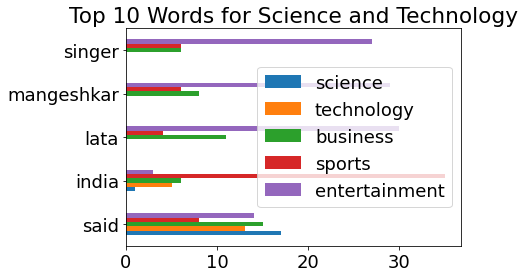

In [56]:
plt.rc('font', size=18)
word_counts.sort_values('all', ascending=False).head(5)[['science', 'technology', 'business', 'sports', 'entertainment']].plot.barh()
plt.title('Top 10 Words for Science and Technology')

# Takeaways
**Out of all words in all categories:**
* 'said' is the most common word.
* Sports news includes 'India' the most.
* Business mentions 'crore' the most.
* The word 'billion' is used the most in technology articles.
* Sports and Entertainment use the word 'added' the most.

## Visualize the top 10 words for each category.

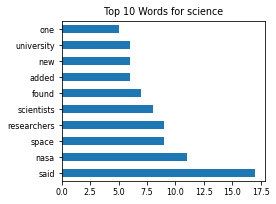

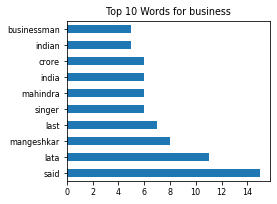

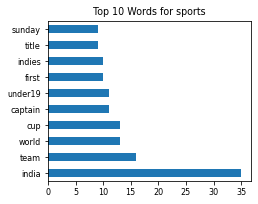

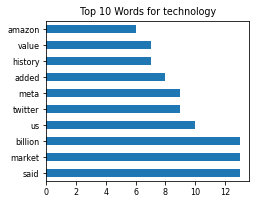

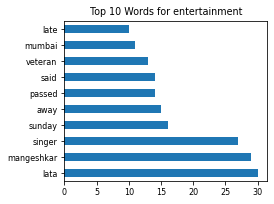

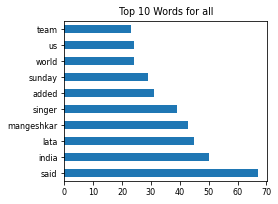

In [57]:
n = 1
for category in list(word_counts.columns):
    plt.rc('font', size=8)
    plt.figure(figsize=(8,10))
    plt.subplot(3,2,n)
    word_counts[category].sort_values(ascending=False).head(10).plot.barh()
    plt.title(f'Top 10 Words for {category}')
    n += 1

# Takeaways
* 'said' and 'added'(another form of said) are the most commonly used words in news.
* The news is a lot of 'He said/She said/They said"
* Actor is mentioned more than actress in entertainment news.
* Entertainment likes to mention films and Instagram.
* Meta and Facebook dominated technology news.
* Sports news is very nationalistic.
* NASA and space are mentioned a lot in science news.

In [58]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

* Find the top 10 longest words for each category.
* Find the average word length for each category.
* Find words that are unique to each category.

I want to create a function that will intake any text and analyze the shit out of it. I want a total character count, character count for the longest word, longest lenth sentence(and that printed), average wordlength per sentence, shortest word(& character count), longest word(& character count), 

In [59]:
def analyze_text(string):
    # Get length of total characters in all cleaned science articles.
    total_characters = len(string)
    print(f'Total amount of characters: {total_characters}')
    
    # Get wordcount of all words in cleaned science articles.
    total_words = len(string.split())
    print(f'Total amount of words: {total_words}')
    
    # Get list of unique words and a count in cleaned science articles.
    unique_words = pd.DataFrame(string.split())[0].unique()
    print('Total amount of unique words: ',len(unique_words)
          
    # Get length of every unique word and plot a histogram of how many times each length of word appears.
    sns.histplot([len(word) for word in unique_words], binwidth=1)
    plt.xlabel('character_count')
    plt.title('Number of Characters in Each Word')

SyntaxError: invalid syntax (4218005345.py, line 15)

In [60]:
# Get length of total characters in all cleaned science articles.
len(science_words)

7033

In [61]:
# Get wordcount of all words in cleaned science articles.
len(science_words.split())

931

In [62]:
# Get list of unique words and a count in cleaned science articles.
unique_words = pd.DataFrame(science_words.split())[0].unique()

len(unique_words)

648

Text(0.5, 1.0, 'Number of Characters in Each Word')

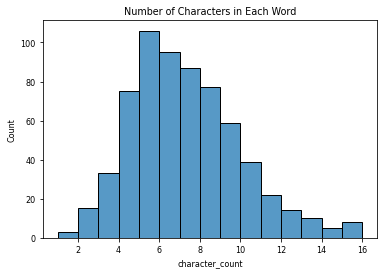

In [63]:
# Get length of every unique word and plot a histogram of how many times each length of word appears.
sns.histplot([len(word) for word in unique_words], binwidth=1)
plt.xlabel('character_count')
plt.title('Number of Characters in Each Word')

# Takeaways
* The distribution of word length is slightly right skewed.

In [64]:
# Get average word length of all words in cleaned science articles.
pd.Series([len(word) for word in unique_words]).mean()

6.810185185185185